In [1]:
# 导入包

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix

%matplotlib inline

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# 导入清洗后的数据集

df = pd.read_csv("data_cleaned.csv")
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2014-03-12,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,2014-03-17,Closed with explanation,Yes,No,759217
1,2017-01-19,Student loan,Federal student loan servicing,Dealing with the lender or servicer,Received bad information about my loan,When my loan was switched over to Navient i wa...,NaN,"Navient Solutions, LLC.",LA,NaN,NaN,Consent provided,Web,2017-01-19,Closed with explanation,Yes,No,2296496
2,2018-04-06,Credit card/Prepaid card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,I tried to sign up for a spending monitoring p...,NaN,CAPITAL ONE FINANCIAL CORPORATION,VA,NaN,Older American,Consent provided,Web,2018-04-06,Closed with explanation,Yes,NaN,2866101
3,2014-06-08,Credit card/Prepaid card,Credit card,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,2014-06-10,Closed with explanation,Yes,Yes,885638
4,2014-09-13,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,2014-09-13,Closed with explanation,Yes,Yes,1027760


In [3]:
# 为了简化模型，我们只研究投诉量最高的产品'Credit reporting'
# 及主题‘Incorrect information on credit report’、"Problem with a credit reporting company's investigation into an existing problem"

df_clean = df[(df['Product']=='Credit reporting') & 
              (df['Issue'].isin(['Incorrect information on credit report',
                                 "Problem with a credit reporting company's investigation into an existing problem"]))]
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63790 entries, 12 to 279960
Data columns (total 18 columns):
Date received                   63790 non-null object
Product                         63790 non-null object
Sub-product                     34472 non-null object
Issue                           63790 non-null object
Sub-issue                       63790 non-null object
Consumer complaint narrative    14999 non-null object
Company public response         29626 non-null object
Company                         63790 non-null object
State                           63118 non-null object
ZIP code                        59648 non-null object
Tags                            7117 non-null object
Consumer consent provided?      38512 non-null object
Submitted via                   63790 non-null object
Date sent to company            63790 non-null object
Company response to consumer    63790 non-null object
Timely response?                63790 non-null object
Consumer disputed?        

In [4]:
# 分别使用决策树及随机森林预测‘Company response to consumer’

In [5]:
## 数据预处理

### 删除数据集中不用于建模的列
df_model_0 = df_clean.drop(['Product',
                            'Date received',
                            'Issue',
                            'Sub-product',
                            'Sub-issue',
                            'Consumer complaint narrative',
                            'Complaint ID',
                            'Date sent to company',
                            'Tags',
                            'Consumer consent provided?',
                            'ZIP code'],
                             axis=1)

### 预处理1——缺失值
#### ‘Company public response’、‘Consumer consent provided?’及‘Consumer disputed? ’缺失值接近数据集的一半，无法获取，予以删除；
#### ‘State’和‘Consumer consent provided?’相较而言缺失值较少，也无法获取，予以删除；

df_model_1 = df_model_0.dropna()
df_model_2 = df_model_1.copy()
df_model_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10708 entries, 14 to 279955
Data columns (total 7 columns):
Company public response         10708 non-null object
Company                         10708 non-null object
State                           10708 non-null object
Submitted via                   10708 non-null object
Company response to consumer    10708 non-null object
Timely response?                10708 non-null object
Consumer disputed?              10708 non-null object
dtypes: object(7)
memory usage: 669.2+ KB


In [6]:
##### 仅为了后面的特征分析（绘制特征相关图形），这里我们先将所有特征同时进行facrorizing
cols = ['Company public response',
        'Company',
        'State',
        #'ZIP code',
        'Company response to consumer',
        'Submitted via',
        'Timely response?',
        'Consumer disputed?']

for col in cols:
    df_model_1[col] = pd.factorize(df_model_1[col])[0]
df_model_1.info()


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10708 entries, 14 to 279955
Data columns (total 7 columns):
Company public response         10708 non-null int64
Company                         10708 non-null int64
State                           10708 non-null int64
Submitted via                   10708 non-null int64
Company response to consumer    10708 non-null int64
Timely response?                10708 non-null int64
Consumer disputed?              10708 non-null int64
dtypes: int64(7)
memory usage: 669.2 KB


In [7]:
### 预处理2

#### 对于建模分类变量，采取两种方法处理：
#### 类别变量或者二元变量，采取pd.get_dummies()转换为虚拟变量

dummy_cols = ['Submitted via','Timely response?','Consumer disputed?']

for col in dummy_cols:
    df_model_2[col] = df_model_2[col].astype('category')### object——>category
    
df_model = pd.get_dummies(df_model_2,columns=dummy_cols,drop_first=True)

#### 标称属性，即分类等级较多的变量，采取pd.factorize()将每个分类等级映射为唯一的数字表示

df_model['Company public response'] = pd.factorize(df_model['Company public response'])[0]
df_model['Company'] = pd.factorize(df_model['Company'])[0]
df_model['State'] = pd.factorize(df_model['State'])[0]
#df_model['ZIP code'] = pd.factorize(df_model['ZIP code'])[0]
df_model['Company response to consumer'] = pd.factorize(df_model['Company response to consumer'])[0]

df_model.info()
df_model.columns
df_model['Company response to consumer'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10708 entries, 14 to 279955
Data columns (total 10 columns):
Company public response         10708 non-null int64
Company                         10708 non-null int64
State                           10708 non-null int64
Company response to consumer    10708 non-null int64
Submitted via_Phone             10708 non-null uint8
Submitted via_Postal mail       10708 non-null uint8
Submitted via_Referral          10708 non-null uint8
Submitted via_Web               10708 non-null uint8
Timely response?_Yes            10708 non-null uint8
Consumer disputed?_Yes          10708 non-null uint8
dtypes: int64(4), uint8(6)
memory usage: 481.0 KB


0    7100
1    3579
2      19
3      10
Name: Company response to consumer, dtype: int64

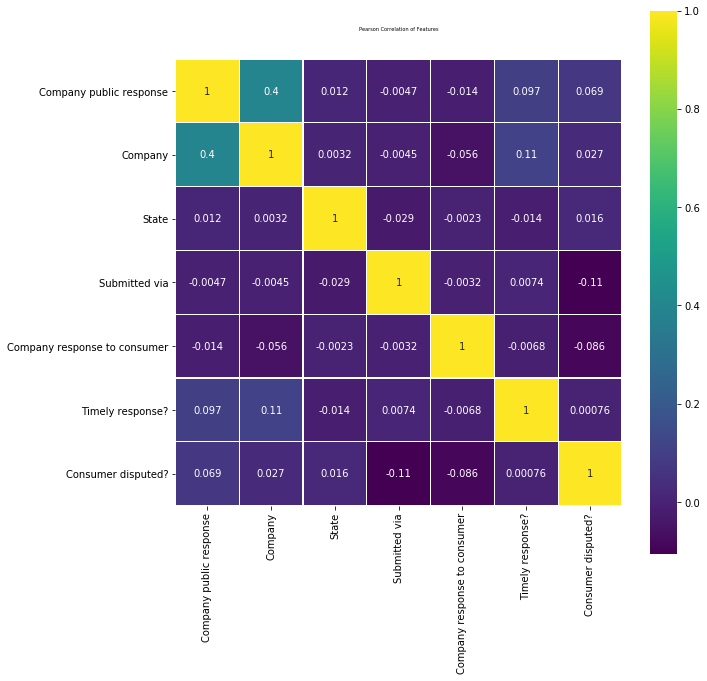

In [8]:
### 特征间相关性分析

colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', y=1.05, size=5)
sns.heatmap(df_model_1.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


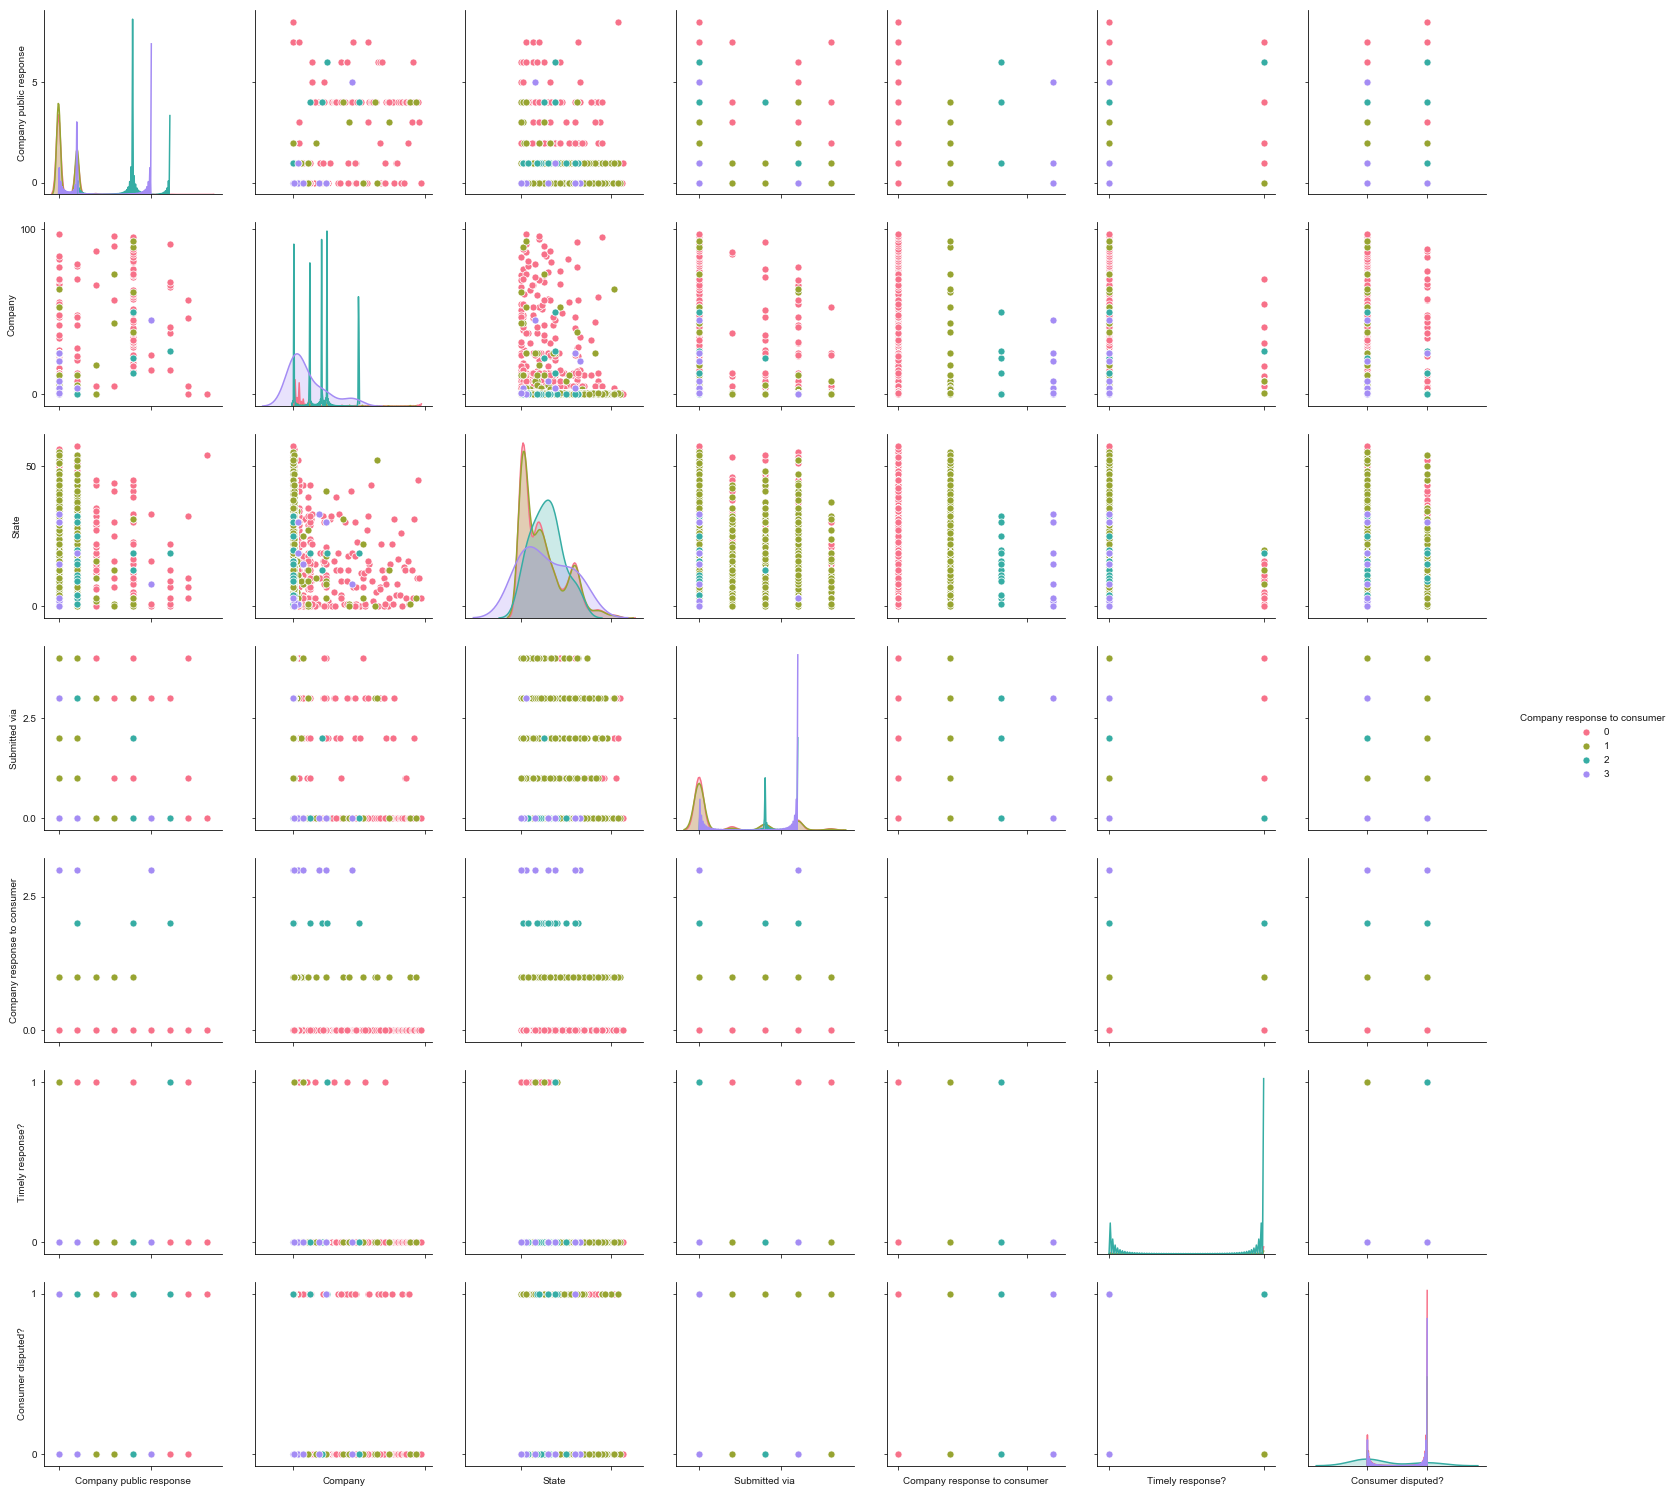

In [9]:
# 特征散点图矩阵展示
g = sns.pairplot(df_model_1, hue='Company response to consumer', palette = 'husl',height=3,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=50) )
g.set(xticklabels=[])
sns.set(font_scale=25)
plt.show()

In [10]:
### 由于上述特征不多，且各自相关性很弱，我们选择所有特征建模
### 将数据分为训练集和测试集
features = [i for i in df_model.columns if i != 'Company response to consumer']
    
X = df_model[features]
y = df_model['Company response to consumer']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [11]:
## 建模——决策树

### 创建决策树分类器
dt_model = DecisionTreeClassifier(random_state=0) 
### 调整参数（基于基尼值和信息增益）
params_dt = {'criterion': ['gini', 'entropy']}
dt_classifier = GridSearchCV(estimator= dt_model, cv=5, param_grid=params_dt)
### 用训练集拟合分类器（没有这个步骤就无法使用best_estimator_属性）
dt_classifier.fit(X_train,y_train)
### 用调整后的参数创建分类器
best_dt_model = DecisionTreeClassifier(criterion = dt_classifier.best_estimator_ .criterion)

In [12]:
### 使用训练集训练模型
best_dt_model.fit(X_train,y_train)
### 模型评分
print(best_dt_model.score(X_test,y_test)) 
### 模型预测
y_pred_dt = best_dt_model.predict(X_test)
### 通过混淆矩阵查看预测值与实际值分布情况
confusion_matrix(y_test, y_pred_dt)

0.6531279178338002


array([[1289,  137,    2,    1],
       [ 597,  110,    0,    0],
       [   2,    1,    0,    0],
       [   1,    2,    0,    0]])

In [13]:
## 模型建立——随机森林
### 创建决策树分类器
rf_model = RandomForestClassifier(random_state=0)
### 调整参数（基于基尼值和信息增益）
params_rf = {'n_estimators': [10, 50, 100, 200, 500], 'criterion': ['gini', 'entropy']}
rf_classifier = GridSearchCV(estimator= rf_model, cv=5, param_grid=params_rf)
### 用训练集拟合分类器
rf_classifier.fit(X_train,y_train)
### 用调整后的参数创建分类器
best_rf_model = RandomForestClassifier(criterion = rf_classifier.best_estimator_ .criterion)

In [14]:
### 将数据分为训练集和测试集
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
### 使用训练集训练模型
best_rf_model.fit(X_train,y_train)
### 模型评分
print(best_rf_model.score(X_test,y_test)) 
### 模型预测
y_pred_rf = best_rf_model.predict(X_test)
### 通过混淆矩阵查看预测值与实际值分布情况
confusion_matrix(y_test, y_pred_rf)

0.6493930905695612


array([[1254,  202,    0,    0],
       [ 544,  137,    0,    0],
       [   3,    1,    0,    0],
       [   1,    0,    0,    0]])

In [ ]:
# 总结

## 最终模型得分不是很高，可能由于分析数据的特征值不充足。该数据集中仅包含金融公司名称、产品（子产品）、投诉主题（子主题）、
## 投诉人信息（例如居住州、zip code）、投诉渠道、投诉是否上诉等特征。
## 后期有必要收集更多数据用于建模，包括具体的投诉人信息，例如年龄、性别、工作、收入、受教育程度，以及金融公司对投诉的具体回应内容等。